In [19]:
import numpy as np
from scipy.special import digamma, gammaln
from sklearn.cluster import KMeans
xrange = range

def logsumexp(arr, axis=0):  
    """Computes the sum of arr assuming arr is in the log domain.
    Returns log(sum(exp(arr))) while minimizing the possibility of
    over/underflow."""
    arr = np.rollaxis(arr, axis)
    # Use the max to normalize, as with the log this is what accumulates
    # the less errors
    vmax = arr.max(axis=0)
    out = np.log(np.sum(np.exp(arr - vmax), axis=0))
    out += vmax
    return out

def log_normalize(v, axis=0):
    """Normalized probabilities from unnormalized log-probabilites"""
    v = np.rollaxis(v, axis)
    v = v.copy()
    v -= v.max(axis=0)
    out = logsumexp(v)
    v = np.exp(v - out)
    v += np.finfo(np.float32).eps
    v /= np.sum(v, axis=0)
    return np.swapaxes(v, 0, axis)

'''
alpha ~ Gamma(1, 1)
V ~ Beta(1, alpha)
C ~ SBP(V)
Mu ~ Normal(0, I)
(tau)~ Gamma(1, 1)
X ~ N(Mu, tau^-1I_p)

q(vt) ~ Beta(vt | gamma_t,1, gamma_t,2)
q(cn) ~ Discrete(zn | phi_n)
q(mu_t) ~ Normal(mean_mu, nglambda)
q(tau_t) ~ Gamma(a_tao, b_tao)
'''
class VDPGMM(object):
    def __init__(self, T, max_iter = 50, alpha = 1, thresh=1e-3, verbose=False):
        self.T = T
        self.max_iter = max_iter
        self.alpha = alpha
        self.thresh = thresh
        self.verbose = verbose

    _log_normalize = staticmethod(log_normalize)

    def _initialize(self, X):
        self.X = X
        self.N, self.P = X.shape

        # mu
        # self.mean_mu = np.zeros((self.T, self.P))
        self.mean_mu = KMeans(n_clusters=self.T).fit(X).cluster_centers_[::-1]
        self.cov_mu = np.empty((self.T, self.P, self.P))
        for i in xrange(self.T):
            self.cov_mu[i] = np.eye(self.P)

        # tao
        self.a_tao = np.ones(self.T)
        self.b_tao = np.ones(self.T) 

        # v
        self.gamma = self.alpha * np.ones((self.T, 2))

        # c
        self.phi = np.ones((self.T, self.N)) / self.T
        self.Nt = np.sum(self.phi, axis = 1)

        #hyper
        self.a0 = 1
        self.b0 = 1

        self.lbs = []
        self.converge = False

        self.bound_X = self._bound_x(self.X)

    def _bound_x(self, X):
        N, P = X.shape
        bound_x = np.empty((self.T, N))
        for t in xrange(self.T):
            bound_x[t] = np.sum((X - self.mean_mu[t])**2, axis = 1) + np.trace(self.cov_mu[t])
        return bound_x

    def _update(self, X):
        #E STEP
        self.phi, self.Nt = self._update_c(self.bound_X)

        #M STEP
        self.update_v()
        self.update_mu()

        self.bound_X = self._bound_x(self.X)
        self.update_tao(self.bound_X)

    def print_log(self, n=0):
        clusters = np.argmax(self.phi, axis=0)
        #print 'n=%d, clusters=%d %s'%(n + 1, len(np.unique(clusters)), np.unique(clusters))
        
        #print [np.sum(clusters == label) for label in np.unique(clusters)] 

        #print 'lowerbound ', self.lbs[-1]
        
        if len(self.lbs) > 1:
            eps = self.lbs[-1] - self.lbs[-2]
            #print 'eps:%f, diff:%.5f%%'%(eps, 100 * (self.lbs[-1] - self.lbs[-2]) / np.abs(self.lbs[-2]))

    def _do_fit(self, update_func):
        self.lbs = []
        n_iter = self.max_iter
        self.converge = False
        for i in xrange(n_iter):
            update_func()

            self.lbs.append(self.lowerbound())

            if self.verbose:
                self.print_log(i)

            if self.thresh is not None and len(self.lbs) > 1 and \
                100 * (self.lbs[-1] - self.lbs[-2]) / np.abs(self.lbs[-2]) < self.thresh:
                self.converge = True
                break

    def fit(self, X):
        self._initialize(X)

        update_func = lambda: self._update(self.X)

        self._do_fit(update_func)

    def update_mu(self):
        for t in xrange(self.T):
            tao_t = self.a_tao[t] / self.b_tao[t]
            Nt = np.sum(self.phi[t])
            self.cov_mu[t] = np.linalg.inv((tao_t*Nt + 1)*np.eye(self.P))
            self.mean_mu[t] = tao_t * self.cov_mu[t].dot(self.X.T.dot(self.phi[t]))

    def update_tao(self, bound_X):
        for t in xrange(self.T):
            self.a_tao[t] = self.a0 + .5 * self.P * np.sum(self.phi[t])
            self.b_tao[t] = self.b0 + .5 * np.sum(np.multiply(self.phi[t], bound_X[t]))

    def update_v(self):
        sum_phi = self.Nt
        self.gamma[:, 0] = 1 + sum_phi
        phi_cum = np.cumsum(self.phi[:0:-1, :], axis = 0)[::-1, :]
        self.gamma[:-1, 1] = self.alpha + np.sum(phi_cum, axis = 1)

    def _log_lik_pi(self):
        sd = digamma(self.gamma[:, 0] + self.gamma[:, 1])
        logv = digamma(self.gamma[:, 0]) - sd
        sum_lognv = np.zeros(self.T)
        for t in xrange(1, self.T):
            sum_lognv[t] = sum_lognv[t-1] + digamma(self.gamma[t-1, 1]) - sd[t-1]

        likc = logv + sum_lognv
        likc[-1] = np.log(1 - (sum(np.exp(likc[:-1]))))

        return likc

    def _log_lik_x(self, bound_X):
        likx = np.zeros(bound_X.shape)
        for t in xrange(self.T):
            likx[t, :] = .5*self.P*(digamma(self.a_tao[t]) - np.log(self.b_tao[t]) - np.log(2*np.pi))
            tao_t = self.a_tao[t] / self.b_tao[t]
            likx[t, :] -= .5 * tao_t * bound_X[t]
        return likx

    def _update_c(self, bound_X):
        likc = self._log_lik_pi()

        likx = self._log_lik_x(bound_X)

        s = likc[:, np.newaxis] + likx

        phi = self._log_normalize(s, axis=0)

        return phi, np.sum(self.phi, axis = 1)

    def lowerbound(self):
        lb = 0
        T = self.T
        gamma = self.gamma
        sd = digamma(gamma[:, 0] + gamma[:, 1])
        dg0 = digamma(gamma[:, 0]) - sd
        dg1 = digamma(gamma[:, 1]) - sd
        #V
        alpha = self.alpha
        # Eq[log p(V | 1, alpha)]
        lpv = (gammaln(1 + alpha) - gammaln(alpha)) * T \
            + (alpha - 1) * np.sum(dg1)
        # Eq[log q(V | gamma1, gamma2)]
        lqv = np.sum(gammaln(gamma[:, 0] + gamma[:, 1]) \
            - gammaln(gamma[:, 0]) - gammaln(gamma[:, 1]) \
            + (gamma[:, 0] - 1) * dg0 + (gamma[:, 1] - 1) * dg1)
        lb += lpv - lqv

        #mu
        lpmu = 0
        lqmu = 0
        for t in xrange(T):
            # Eq[log p(mu)]
            lpmu += -.5 * (self.mean_mu[t].dot(self.mean_mu[t]) + np.trace(self.cov_mu[t]))
            sign, logdet = np.linalg.slogdet(self.cov_mu[t])
            # Eq[log q(mu | mean_mu, cov_mu)]
            lqmu += -.5 * sign * logdet
        lb += lpmu - lqmu

        #tao
        # Eq[log p(tau)]
        lptao = - np.sum(self.a_tao / self.b_tao)
        # Eq[log q(tau | a_tao, b_tao]
        lqtao = np.sum(-gammaln(self.a_tao) + (self.a_tao-1)*digamma(self.a_tao) \
            + np.log(self.b_tao) - self.a_tao)
        lb += lptao - lqtao

        #c
        phi_cum = np.cumsum(self.phi[:0:-1, :], axis = 0)[::-1, :]
        lpc = 0
        # Eq[log p(Z | V)]
        for t in xrange(T):
            if t < T - 1:
                lpc += np.sum(phi_cum[t] * dg1[t])
            lpc += np.sum(self.phi[t]*dg0[t])
        n_phi = self.phi #[self.phi>np.finfo(np.float32).eps]
        # Eq[log q(Z | phi)]
        lqc = np.sum(n_phi*np.log(n_phi))
        lb += lpc - lqc

        #x
        lpx = 0
        # Eq[log p(X)]
        likx = self._log_lik_x(self.bound_X)
        lpx = np.sum(self.phi * likx)

        lb += lpx
        return lb

    def predict(self, X):
        bound_X = self._bound_x(X)
        phi, _ = self._update_c(bound_X)
        clusters = np.argmax(phi, axis=0)
        return clusters

In [20]:
import numpy as np
import hdbscan

In [21]:
cd '/Users/aidasaglinskas/Downloads/stuff/star-clustering-master/'

/Users/aidasaglinskas/Downloads/stuff/star-clustering-master


In [22]:
from star_clustering import StarCluster
star = StarCluster()

In [23]:
from sklearn import mixture

In [24]:
def get_data(numClust = 3,ndim = 10,spread=.1,pointsPerClust=100):
    data=list();
    for c in range(numClust):
        mu = np.repeat(c,ndim);
        cov = np.eye(len(mu))*spread;
        if type(pointsPerClust)==int:
            n = pointsPerClust
        else:
            n = pointsPerClust[c]   
    #    pointsPerClust = 100
        vec = np.random.multivariate_normal(mu,cov,n);
        zc = np.repeat(c,vec.shape[0])
        if c==0:
            data=vec
            z = zc;
        else:
            data = np.vstack((data,vec))
            z = np.hstack((z,zc))
    print(data.shape)
    return data,z

In [31]:
from sklearn.manifold import MDS
from matplotlib import pyplot as plt;

def test_clusters(data,z):
    print('ndim={}'.format(data.shape[1]))
    embedding = MDS(n_components=2, metric=True, n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=None, random_state=1, dissimilarity='euclidean')
    X_transformed = embedding.fit_transform(data,)

    plt.figure(figsize=np.array((7,5))*1.5)

    plt.subplot(2,2,1);
    plt.scatter(X_transformed[:,0],X_transformed[:,1],c=z);
    plt.title('Ground truth: {}'.format(len(np.unique(z))),fontsize=15);

    plt.subplot(2,2,2);
    #star.fit(data);
    DPGMM = VDPGMM(50)
    DPGMM.fit(data)
    
    plt.scatter(X_transformed[:,0],X_transformed[:,1],c=DPGMM.predict(data));
    plt.title('VDPGMM: {}'.format(len(np.unique(DPGMM.predict(data)))),fontsize=15);
    
    model = mixture.BayesianGaussianMixture(max_iter=100000,
                                      n_components=106,covariance_type=['full', 'tied', 'diag', 'spherical'][2],
                                      init_params='random',tol=0.00001,
                                      weight_concentration_prior_type='dirichlet_process',weight_concentration_prior=[None,.1,1,100][0],mean_precision_prior=None)
    
    plt.subplot(2,2,3);
    model.fit(data);
    bnpz = model.predict(data);
    plt.scatter(X_transformed[:,0],X_transformed[:,1],c=bnpz);
    plt.title('BNP clustering: {}'.format(len(np.unique(bnpz))),fontsize=15);

    plt.subplot(2,2,4);
    clusterrer = hdbscan.HDBSCAN();
    clusterrer.fit(data);
    plt.scatter(X_transformed[:,0],X_transformed[:,1],c=clusterrer.labels_);
    plt.title('HDBSCAN clustering: {}'.format(len(np.unique(clusterrer.labels_))),fontsize=15);


(300, 3)
ndim=3


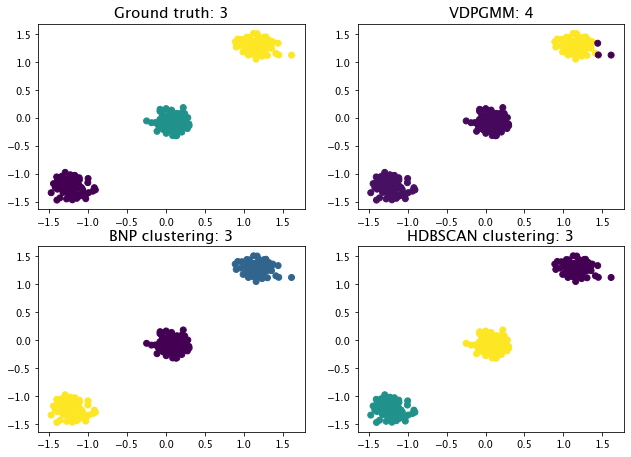

In [32]:
data,z = get_data(numClust = 3,ndim = 3,spread=.01,pointsPerClust=100)
test_clusters(data,z)

(300, 15)
ndim=15


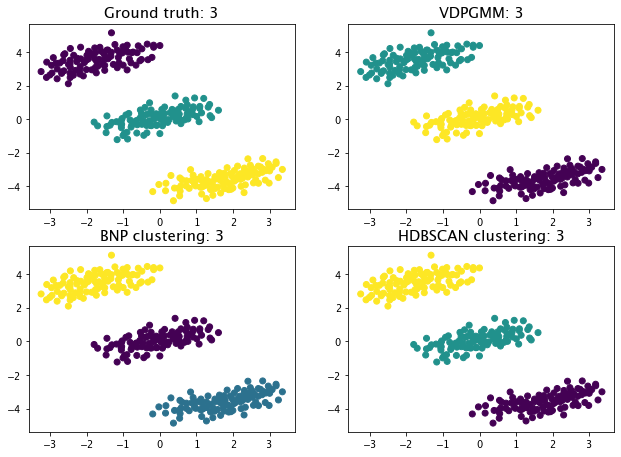

In [51]:
data,z = get_data(numClust = 3,ndim = 15,spread=.1,pointsPerClust=100)
test_clusters(data,z)

(140, 2)
ndim=2


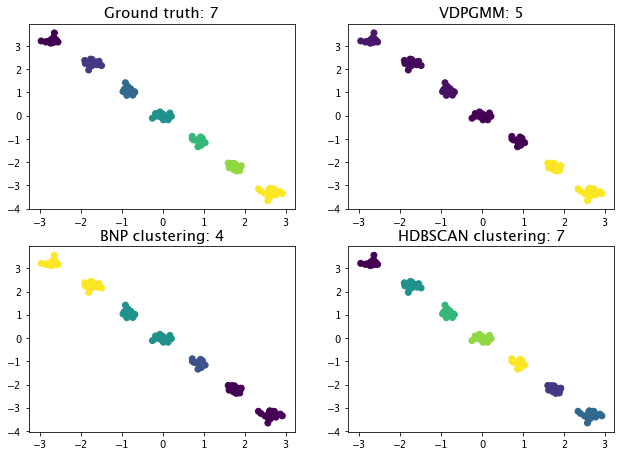

In [34]:
data,z = get_data(numClust = 7,ndim = 2,spread=.01,pointsPerClust=20)
test_clusters(data,z)

(300, 3)
ndim=3


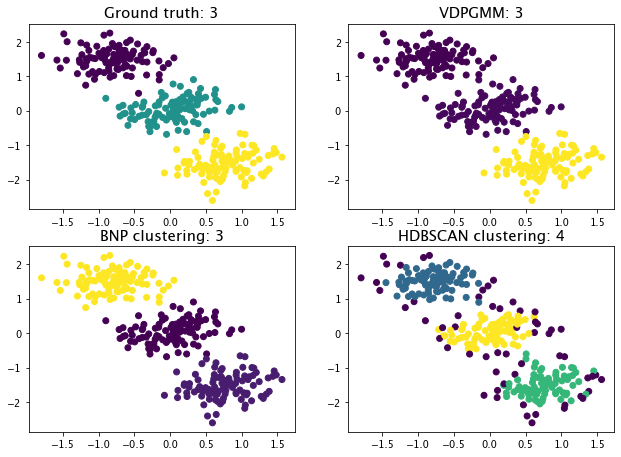

In [40]:
data,z = get_data(numClust = 3,ndim = 3,spread=.1,pointsPerClust=100)
test_clusters(data,z)

(300, 20)
ndim=20


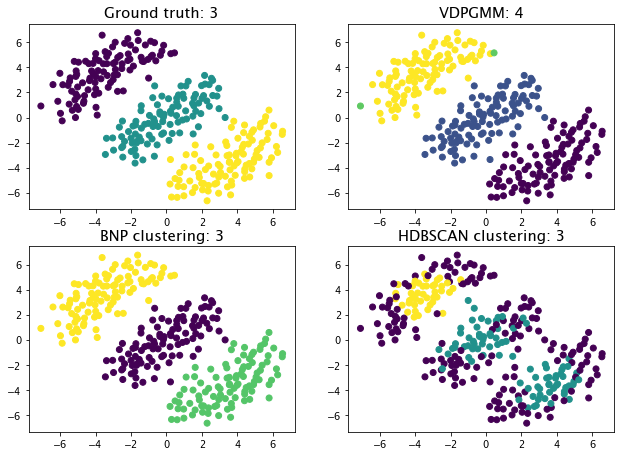

In [36]:
data,z = get_data(numClust = 3,ndim = 20,spread=.5,pointsPerClust=100)
test_clusters(data,z)

(555, 2)
ndim=2


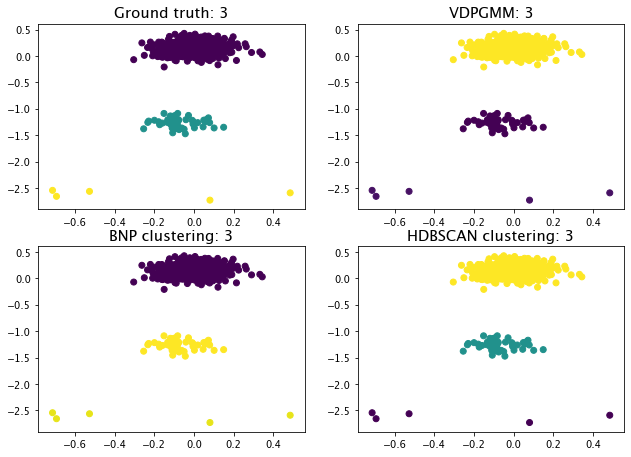

In [47]:
data,z = get_data(numClust = 3,ndim = 2,spread=.01,pointsPerClust=[500,50,5])
test_clusters(data,z)

(555, 20)
ndim=20


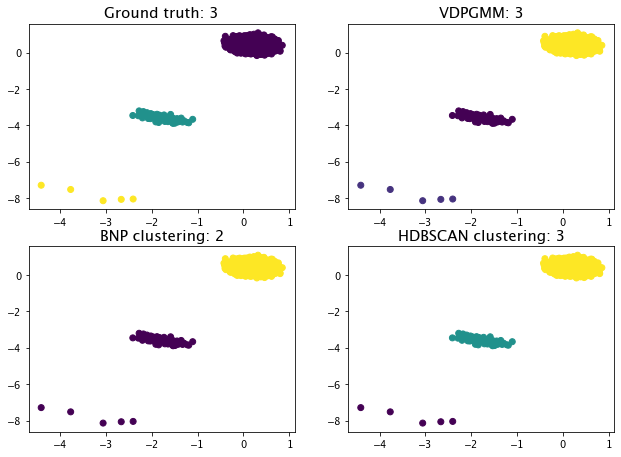

In [52]:
data,z = get_data(numClust = 3,ndim = 20,spread=.01,pointsPerClust=[500,50,5])
test_clusters(data,z)

(3000, 3)
ndim=3


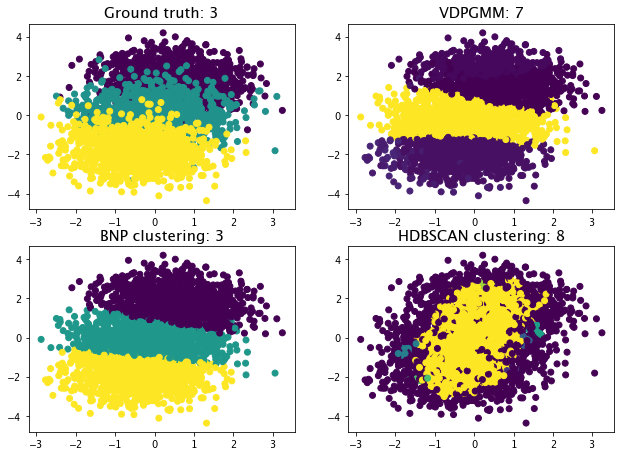

In [53]:
data,z = get_data(numClust = 3,ndim = 3,spread=.6,pointsPerClust=1000)
test_clusters(data,z)